In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import mwclient #for getting wikipedia data
from bs4 import BeautifulSoup #for extracting desired information from html data
from bs4 import Comment #for looking through comments

import string #for string processing
import locale #for turning string to number
import re #for string processing

# Airport contagion

Things we are trying to accomplish in this notebook are:
- Run a simulation of COVID-19 spreading with set locations (airports) as the only places on earth
- Get the same number of cases across the world out of the simulations as observed with real data
- Find and use an adequate metric with which to determine if the simulation is close enough



Data taken from [European CDC](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide).

In [2]:
df = pd.read_csv("covid_data.csv")
df.sort_values(by = ['year', 'month', 'day', 'countriesAndTerritories'], ascending = True, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,31/12/2019,31,12,2019,0,0,Afghanistan,AF,AFG,37172386.0
1,31/12/2019,31,12,2019,0,0,Algeria,DZ,DZA,42228429.0
2,31/12/2019,31,12,2019,0,0,Armenia,AM,ARM,2951776.0
3,31/12/2019,31,12,2019,0,0,Australia,AU,AUS,24992369.0
4,31/12/2019,31,12,2019,0,0,Austria,AT,AUT,8847037.0


The goal is to use the empirical infectiousness of COVID-19 and simulate the spread of the virus over time, based on 24 timesteps (1 for every hour) in a day, where at every step, we have a chance equal to the infectiousness that another person gets the disease.

First let's write a function that is able to plot the number of cases and deaths in a given '#-days running average' period, by default 7 days.

In [12]:
def plot_spread(pltDf, countries = ['World'], ra_length = 7):
    #plots number of cases over time for specified countries
    
    if countries[0] != "World":
        pltDf = pltDf[pltDf["countriesAndTerritories"].isin(countries)]
    
    #the country data
    all_dates = pltDf['dateRep'].unique()
    all_days_cases = []
    all_days_deaths = []
    ra_cases = []
    ra_deaths = []
    label_indices = []
    label_names = []
    num_to_month = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}
    for days_since_outbreak, date in enumerate(all_dates):
        tempDf = pltDf[pltDf['dateRep'] == date]
        cases_day = tempDf['cases'].sum()
        all_days_cases.append(cases_day)       
        deaths_day = tempDf['deaths'].sum()
        all_days_deaths.append(deaths_day)
        
        #for ra_length day running average
        seven_ra_c = []
        seven_ra_d = []
        for i in range(ra_length):
            try:
                seven_ra_c.append(all_days_cases[days_since_outbreak-i])
                seven_ra_d.append(all_days_deaths[days_since_outbreak-i])
            except:
                pass
        ra_cases.append(np.mean(seven_ra_c))
        ra_deaths.append(np.mean(seven_ra_d))

        #set up label indices
        if tempDf.iloc[0]['day'] == 1:
            label_indices.append(days_since_outbreak)
            label_names.append(num_to_month[tempDf.iloc[0]['month']])
            
            
    ### Plotting Stuff ###
    
    fig,ax = plt.subplots(1,1,figsize=(15,8))
    
    ctry_string = ""
    for c in countries:
        ctry_string += c + ", "
    title = "{:d}-Day Running Average of {:s}".format(ra_length, ctry_string[:-2])
    
    ax.set_title(title)
    cplot = ax.plot(ra_cases, color = 'steelblue', label = "Daily Cases")
    cycord = cplot[0].get_ydata()[-1]
    cxcord = cplot[0].get_xdata()[-1]
    ax.annotate('{:.0f} Cases'.format(cycord),
            xy=(cxcord, cycord),
            xytext=(0, 5),  # 5 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')
    dplot = ax.plot(ra_deaths, color = 'red', label = "Daily Deaths")
    dycord = dplot[0].get_ydata()[-1]
    dxcord = dplot[0].get_xdata()[-1]
    ax.annotate('{:.0f} Deaths'.format(dycord),
            xy=(dxcord, dycord),
            xytext=(0, 5),  # 5 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')
    
    ax.set_ylabel("Number of People")
#     ax.set_xlabel("Time")
    ax.set_xticks(label_indices)
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr'])
    ax.legend()
    
    plt.show()

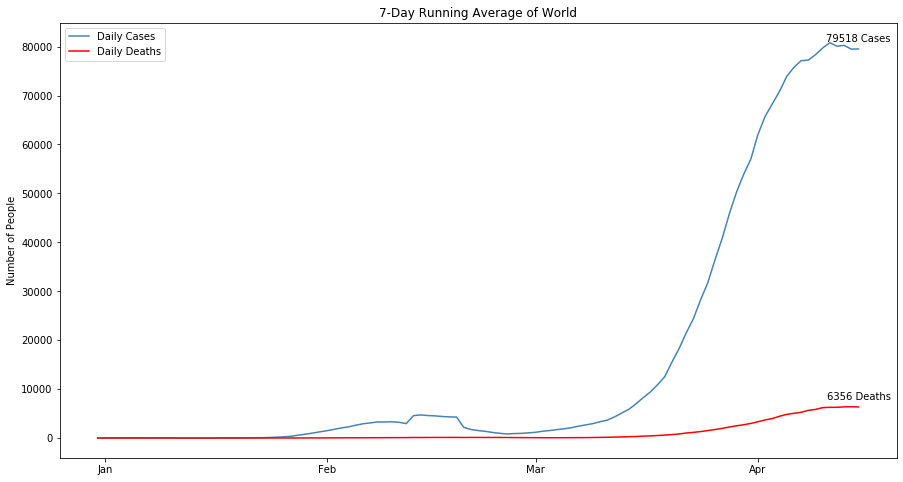

In [13]:
plot_spread(df, countries = ["World"])

Now that we have a function that we can plot the spread of the disease with, let's get into writing a simulation. What we need from the simulation is:
- Start in China
- 


From a high level, the idea is that if we assume that we have a simulation that is 'perfect', we would be able to determine almost exactly the number of daily cases as observed. Furthermore, if we have a simulation that 'perfectly' incapsulates airports and airtraffic -- and only those -- we should be able to compare and contrast the data we get (through some magic metric we have yet to find out) with the observations, and through that find out how much airports alone contributed to the spread of COVID-19.

Question 1:
- How contagious are airports?

Question 2:
- How much of the COVID-19 spread can be explained by airports?

Question 3:
- How responsible are airports for the coronavirus spread to other countries?

To determine the impact of air travel on disease spread, we measure the following:
- Only United States impact
- Dealing with continued income of infected people from outside U.S., either  
  - start with when the US closed its international airtravel (January 31st)
  - OR start from the beginning (with the first 4 cases, and randomly adding some to account for income)
- Measure only the states

In [14]:
df_us = pd.read_csv('https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/JHU_USCountymap/df_Counties2020.csv')
df_us.drop(labels = 'Unnamed: 0', axis=1, inplace = True)
df_us.tail()

,Countyname,ST_Name,FIPS,ST_ID,dt,Confirmed,Deaths
344813,Nelson,Kentucky,21179,21.0,2020-05-06,24,0.0
344814,Nicholas,Kentucky,21181,21.0,2020-05-06,1,0.0
344815,Ohio,Kentucky,21183,21.0,2020-05-06,62,0.0
344816,Meade,Kentucky,21163,21.0,2020-05-06,17,1.0
344817,NaN,Grand Princess,99999,NaN,2020-05-06,103,3.0


In [15]:
df_us.sort_values(by=['ST_Name', 'dt'], inplace=True)
df_us.head()

,Countyname,ST_Name,FIPS,ST_ID,dt,Confirmed,Deaths
5,Autauga,Alabama,1001,1.0,2020-01-22,0,0.0
6,Baldwin,Alabama,1003,1.0,2020-01-22,0,0.0
7,Barbour,Alabama,1005,1.0,2020-01-22,0,0.0
8,Bibb,Alabama,1007,1.0,2020-01-22,0,0.0
9,Blount,Alabama,1009,1.0,2020-01-22,0,0.0


## Getting US cities with primary airports

Using the MediaWiki API with the mwclient library, we can get the parsed data of a wikipedia page. With that, we gain access to information in the tables of the wiki page. If we didn't do this, we would just see the code that should populate the table, not the table after it is parsed.

In [142]:
site = mwclient.Site("en.wikipedia.org")
result = site.api('parse', prop='text', pageid=4718801) #using pageid here, because I couldn't get the call to work with the title
airports = result['parse']["text"]["*"]

Since the data is in html form, we can use BeautifulSoup to extract desired information.

In [143]:
soup = BeautifulSoup(airports, 'html.parser')

After looking at the data a bit, I noticed that the information we're after is in the third table of the page, so we first get the third table tag, and then we go through each row, keeping only the city name.

In order convert the cities to population count, we need to keep the cities ordered by their state. This also helps dealing with duplicate names like Portland, which is a city in both Oregon and Maine.

In [144]:
#get the table that has contains all of the primary airport names
airport_table = soup.findAll("table")[2]

# find all rows, which are indicated by the 'tr' tag, then get the first element (which is the city), indicated by the 'td' tag
#   furthermore, we need to check if 'td' tag exists and if it does, if it has a 'cite' tag, 
#   which indicates that the current row is actually just indicating a new state (in which case we make a new key in the dict),
#   otherwise we can add a state
airport_cities_by_state = {}
current_state = ""
for row in airport_table.findAll("tr"):
    if(row.find('td')):
        if row.find('td').find("cite"):
            current_state = row.find('td').text
            if current_state == "AMERICAN SAMOA": #this indicates that we are now covering US territories
                break
            else:
                airport_cities_by_state[current_state] = []
        else:
            new_city = row.find('td').text[:-1] #leave out the last character since it's a newline character
            
            #check for edge cases
            if new_city.find(', ') >= 0:
                #handles hawaii city names that include island name
                new_city = new_city[:new_city.find(', ')]
                
            if new_city.find('/') >= 0:
                #this case is tricky, so simply don't worry about it, the '/' indicates multiple city names, so choosing the right one is tough
                new_city = new_city[:new_city.find('/')]
                
            airport_cities_by_state[current_state].append(new_city) 
    

In [145]:
airport_cities_by_state

{'ALABAMA': ['Birmingham', 'Dothan', 'Huntsville', 'Mobile', 'Montgomery'],
 'ALASKA': ['Anchorage',
  'Anchorage',
  'Anchorage',
  'Aniak',
  'Barrow',
  'Bethel',
  'Cordova',
  'Deadhorse',
  'Dillingham',
  'Fairbanks',
  'Galena',
  'Homer',
  'Juneau',
  'Kenai',
  'Ketchikan',
  'King Salmon',
  'Kodiak',
  'Kotzebue',
  'Nome',
  'Petersburg',
  'Sitka',
  "St. Mary's",
  'Unalakleet',
  'Unalaska',
  'Valdez',
  'Wrangell',
  'Yakutat'],
 'ARIZONA': ['Bullhead City',
  'Flagstaff',
  'Grand Canyon',
  'Mesa',
  'Page',
  'Peach Springs',
  'Phoenix',
  'Tucson',
  'Yuma'],
 'ARKANSAS': ['Fayetteville', 'Fort Smith', 'Little Rock', 'Texarkana'],
 'CALIFORNIA': ['Arcata',
  'Bakersfield',
  'Burbank',
  'Fresno',
  'Long Beach',
  'Los Angeles',
  'Mammoth Lakes',
  'Monterey',
  'Oakland',
  'Ontario',
  'Orange County',
  'Palm Springs',
  'Redding',
  'Sacramento',
  'San Diego',
  'San Francisco',
  'San Jose',
  'San Luis Obispo',
  'Santa Barbara',
  'Santa Maria',
  'San

And there it is! But looking at the list of airport cities, we see some duplicates, like Anchorage. This simply means there is more than one primary airport in that city. For the purpose of this project, we don't care. So we may need to remove duplicate values, but for now let's move on to getting city populations!

## Getting city population with MediaWiki API

#### Background:
After spending some time looking for the ideal database containing all US cities with their estimated population, I came out empty handed. Since the ideal didn't exist, we now are stuck with the next best thing, which is to go to the state specific list-of-cities Wikipedia article and query that.

There is a Wikipedia article that links to all of these, based on the state, so it seems that using their links is the way to go. [This](https://en.wikipedia.org/wiki/Lists_of_populated_places_in_the_United_States) is the article I'm referring to.

In [146]:
#used to convert strings like "1,000" to integer 1000
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8');

In [278]:
def process_state(state_name):
    #capitalize the string and replace whitespaces with underscores
    return string.capwords(state_name.replace(" ", "_"), sep = "_")

def is_city_list(contender_str):
    lc = contender_str.lower()
    if lc.find("cities") >=0 or lc.find("municipalities") >= 0 or lc.find("_incorporated") >= 0:
        return True
    return False

def get_name_and_population_indices(column_names):
    #this will take the first mention of population in the expected table headers as the index for population
    #  more recent population information tend to come first
    name_index = -1
    name_found = False
    pop_index = -1
    pop_found = False
    for i, col_name in enumerate(column_names):
        if not name_found and ("name" in col_name or "city" in col_name or "municipality" in col_name):
#             print("found name at index", i)
            name_index = i
            name_found = True
        if not pop_found and ("pop." in col_name or "population" in col_name or "estimate" in col_name or "2020 census" in col_name):
#             print("found population at index", i)
            pop_index = i
            pop_found = True
        if pop_found and name_found:
            return name_index, pop_index
    return name_index, pop_index
    
def get_indices(soups):
    #given list of soup, extract the index of the correct table
    #  utilizes get_name_and_population_indices
    pni = -1; ppi = -1
    for i, soup in enumerate(soups):
        columns = [col.text.lower() for col in soup.findAll("th")]
#         print(columns)
        pni, ppi = get_name_and_population_indices(columns)
        if pni >= 0 and pni <= 3 and ppi >= 0:
            print("Returning, pni ppi:", pni, ppi)
            return i, pni, ppi
    return 0, pni, ppi #randomly choose the first table
    
def get_city_population_tuple(name, pop):
    try:
        return (name, locale.atoi(text))
    except ValueError:
        #issue is square brackets at the end of the string
        cutoff = pop.find("[")
        return (name, locale.atoi(pop[:cutoff]))
    
def get_soup(page_name):
    result = site.api('parse', prop='text', page=page_name)
    wiki_html = result['parse']['text']['*']
    soup = BeautifulSoup(wiki_html)
#     print(soup)
    redirect = soup.findAll("div", {"class": "redirectMsg"})
    if redirect:
        print("Redirecting")
        return get_soup(redirect[0].find('a').text)
    
#     comments = soup.find_all(string=lambda text: isinstance(text, Comment))
#     if 'Redirect_template' in comments[-2]:
#         redirected_page_name = soup.find('a')
#         return get_soup(redirected_page_name)
    return soup

def text_processing(text):
    # Strip leading and tailing whitespaces, remove newline and extraneou characters
    text = re.sub(r"\n|†|‡|\*|\[*.]", "", text)
    text = text.strip()
    return text

def handle_new_city(populations, candidate_tuple):
    #check if new city is already in the list, if it is, keep the one with higher population, otherwise just append new city
    no_duplicate_tuple = True
    for i, (name, pop) in enumerate(populations):
        if candidate_tuple[0] == name:
            no_duplicate_tuple = False
            if pop > candidate_tuple[1]:
                #do not add repeating cities, keep only the largest population
                break
            else:
                populations[i] = candidate_tuple
    if no_duplicate_tuple:
        populations.append(candidate_tuple)
    return populations


def get_city_populations(cities, page_name):
    cur_soup = get_soup(page_name)
    table_tags = cur_soup.findAll("table")
#     headers = [tag.text for tag in table_tags[0].findAll("th")]
#     print(headers[27])
#     return
    if not table_tags:
        table_tags = cur_soup.findAll("table", {"class": "wikitable sortable"})
        if not table_tags:
            print("No table_tags")
            return None
        
    tindex, nindex, pindex = get_indices(table_tags)
    table = table_tags[tindex]

    if nindex == -1 and pindex == -1:
        print("Could not find either name column nor population column")
        return None
    if nindex == -1:
        print("Could not find name column")
        return None
    if pindex == -1:
        print("Could not find population column")
        return None
    
    populations = []
#     print(table.findAll('tr'))
    for row in table.findAll("tr")[1:]: #start from the third entry because the first is set-up
        subtractor = 0
#         print(row)
        if row.find("th"):
            #this means we need to subtract 1 from the indices, as they assumed all columns to be use the 'td'
            subtractor = 1
        
        possible_city_tags = row.findAll("td") #not a precise way to find the city names, but it doesn't need to be, since we are checking base on our list of cities
        
        #Check if findAll returns a list or none
        if possible_city_tags:
            city_tag = possible_city_tags[nindex-subtractor]
            city = text_processing(city_tag.text)
#             print(city)
            if city in cities:
                #using a try/except statement in order not to have to find("[") in all strings
                populations = handle_new_city(populations, get_city_population_tuple(city, row.findAll("td")[pindex-subtractor].text))
            else:
                try:
                    #if city name is not found in a 'td' tag, we can look at alternative tags
                    alt_city_tag = row.find("th") #as in the case of california, the city names are under 'th' tags
                    alt_city = text_processing(alt_city_tag.text)
                    if alt_city in cities:
                        # from the currrently encountered problem cases, it is only the first column (if any)
                        #   that is represented with a 'th' tag, rather than a 'td' tag, so just reduce pop index by 1 
                        populations = handle_new_city(populations, get_city_population_tuple(alt_city, row.findAll("td")[pindex-subtractor].text))
                except:
                    continue
    return populations

def get_city_pop_dictionary(cities_dict):
    link_soup = get_soup("Lists_of_populated_places_in_the_United_States")
    my_dict = {}
    for state in cities_dict.keys():
#         if state != "VIRGINIA":
#             continue
        print("Now doing:", state)
        for sibling in link_soup.find(id = process_state(state)).parent.find_next_siblings(limit=4)[1:]:
            for contender_tag in sibling.findAll("li"):
                if is_city_list(str(contender_tag)) or len(sibling.findAll('li')) == 1:
                    my_dict[state] = get_city_populations(cities=cities_dict[state], page_name=contender_tag.find("a").attrs['title'])
                    #REMOVE LINES BELOW WHEN DONE DEBUGGING
#                     if my_dict[state] == None:
#                         return my_dict
    return my_dict

city_pop_dict = get_city_pop_dictionary(airport_cities_by_state)

Now doing: ALABAMA
Returning, pni ppi: 0 2
Returning, pni ppi: 0 3
Now doing: ALASKA
Returning, pni ppi: 0 4
Now doing: ARIZONA
Returning, pni ppi: 0 3
Now doing: ARKANSAS
Returning, pni ppi: 1 4
Now doing: CALIFORNIA
Returning, pni ppi: 0 3
Now doing: COLORADO
Returning, pni ppi: 0 7
Now doing: CONNECTICUT
Returning, pni ppi: 0 2
Now doing: DELAWARE
Redirecting
Returning, pni ppi: 1 3
Now doing: FLORIDA
Returning, pni ppi: 1 3
Now doing: GEORGIA
Returning, pni ppi: 1 2
Now doing: HAWAII
Returning, pni ppi: 1 2
Now doing: IDAHO
Returning, pni ppi: 1 2
Now doing: ILLINOIS
Returning, pni ppi: 0 2
Now doing: INDIANA
Returning, pni ppi: 1 2
Now doing: IOWA
Returning, pni ppi: 0 2
Now doing: KANSAS
Returning, pni ppi: 1 2
Now doing: KENTUCKY
Returning, pni ppi: 0 1
Now doing: LOUISIANA
Returning, pni ppi: 0 3
Now doing: MAINE
Returning, pni ppi: 1 2
Now doing: MARYLAND
Returning, pni ppi: 0 3
Now doing: MASSACHUSETTS
Returning, pni ppi: 0 4
Now doing: MICHIGAN
Redirecting
Returning, pni ppi

In [279]:
city_pop_dict

{'ALABAMA': [('Birmingham', 212237),
  ('Dothan', 65496),
  ('Huntsville', 180105),
  ('Mobile', 195111),
  ('Montgomery', 205764)],
 'ALASKA': [('Anchorage', 291826),
  ('Aniak', 501),
  ('Bethel', 6080),
  ('Cordova', 2239),
  ('Dillingham', 2329),
  ('Fairbanks', 31535),
  ('Galena', 470),
  ('Homer', 5003),
  ('Juneau', 31275),
  ('Kenai', 7100),
  ('Ketchikan', 8050),
  ('Kodiak', 6130),
  ('Kotzebue', 3201),
  ('Nome', 3598),
  ('Sitka', 8881),
  ("St. Mary's", 507),
  ('Unalakleet', 688),
  ('Unalaska', 4376),
  ('Valdez', 3976),
  ('Wrangell', 2369)],
 'ARIZONA': [('Bullhead City', 39540),
  ('Flagstaff', 65870),
  ('Mesa', 439041),
  ('Page', 7247),
  ('Phoenix', 1445632),
  ('Tucson', 520116),
  ('Yuma', 93064)],
 'ARKANSAS': [('Little Rock', 19352),
  ('Fort Smith', 8820),
  ('Fayetteville', 7689),
  ('Texarkana', 2991)],
 'CALIFORNIA': [('Arcata', 17231),
  ('Bakersfield', 347483),
  ('Burbank', 103340),
  ('Fresno', 494665),
  ('Long Beach', 462257),
  ('Los Angeles', 3792

In [228]:
airport_cities_by_state["VERMONT"]

['Burlington']

In [238]:
result = site.api('parse', prop='text', page="List of cities and counties in Virginia#List of independent cities")
text = result['parse']['text']['*']

In [239]:
text

'<div class="mw-parser-output"><div class="shortdescription nomobile noexcerpt noprint searchaux" style="display:none">Wikimedia list article</div>\n<div role="note" class="hatnote navigation-not-searchable">See also: <a href="/wiki/List_of_United_States_counties_and_county_equivalents" title="List of United States counties and county equivalents">List of United States counties and county equivalents</a></div>\n<table class="infobox vevent" style="width:22em;float: right; width: 250px; font-size: 90%; text-align: left; border-spacing: 3px;"><tbody><tr><th colspan="2" class="summary" style="text-align:center;font-size:125%;font-weight:bold;font-size: 130%; background-color: #F0F0F0; vertical-align: middle">Independent cities and Counties of Virginia</th></tr><tr><td colspan="2" style="text-align:center"><a href="/wiki/File:Map_of_Virginia_Counties_and_Independent_Cities.svg" class="image"><img alt="Map of Virginia Counties and Independent Cities.svg" src="//upload.wikimedia.org/wikipedi

In [168]:
site.api('parse', prop='text', page="List of municipalities in Illinois")

OrderedDict([('parse',
              OrderedDict([('title', 'List of municipalities in Illinois'),
                           ('pageid', 533773),
                           ('text',
                            OrderedDict([('*',
                                          '<div class="mw-parser-output"><div role="note" class="hatnote navigation-not-searchable">"Cities in Illinois" redirects here. For unincorporated communities, see <a href="/wiki/List_of_unincorporated_communities_in_Illinois" title="List of unincorporated communities in Illinois">List of unincorporated communities in Illinois</a>. For CDPs, see <a href="/wiki/List_of_census-designated_places_in_Illinois" title="List of census-designated places in Illinois">List of census-designated places in Illinois</a>.</div>\n<div class="shortdescription nomobile noexcerpt noprint searchaux" style="display:none">Wikimedia list article</div>\n<p class="mw-empty-elt">\n</p>\n<div class="thumb tright"><div class="thumbinner" style="widt

In [182]:
alabama = soup.find(id = 'Alabama')

In [187]:
print(alabama)
alabama.findParent()

<span class="mw-headline" id="Alabama">Alabama</span>


<h3><span class="mw-headline" id="Alabama">Alabama</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Lists_of_populated_places_in_the_United_States&amp;action=edit&amp;section=2" title="Edit section: Alabama">edit</a><span class="mw-editsection-bracket">]</span></span></h3>

In [198]:
alabama

<span class="mw-headline" id="Alabama">Alabama</span>

In [210]:
alabama.previous.find_next_siblings(limit=3)[2]

<ul><li><a href="/wiki/List_of_cities_and_towns_in_Alabama" title="List of cities and towns in Alabama">Cities and towns in Alabama</a></li></ul>

In [206]:
alabama.find_previous().find_next_sibling().find_next_sibling().find_next_sibling()

<ul><li><a href="/wiki/List_of_cities_and_towns_in_Alabama" title="List of cities and towns in Alabama">Cities and towns in Alabama</a></li></ul>

In [197]:
dir(alabama)

['HTML_FORMATTERS',
 'XML_FORMATTERS',
 '__bool__',
 '__call__',
 '__class__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_all_strings',
 '_find_all',
 '_find_one',
 '_formatter_for_name',
 '_is_xml',
 '_lastRecursiveChild',
 '_last_descendant',
 '_should_pretty_print',
 'append',
 'attrs',
 'can_be_empty_element',
 'childGenerator',
 'children',
 'clear',
 'contents',
 'decode',
 'decode_contents',
 'decompose',
 'descendants',
 'encode',
 'encode_contents',
 'extend',
 'extract',
 'fetchNextSiblings',
 'fetchParents',
 'fetchPrevious',
 'fetc